In [51]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.constants as c
import urllib
from io import StringIO
import os
import re


#from plthelper import *

%config InlineBackend.print_figure_kwargs={'facecolor' : "w"}

plt.rcParams["font.family"] = "Times New Roman"
plt.rcParams["font.size"] = 12

output_directory = "../files/output_geant4/background/mDOM/"

In [226]:
def verification_plot(self):

    fig, ax = plt.subplots(2,3, figsize = (15,10))
    ax = ax.flatten()
    texts = [r"$\alpha$", r"$e^-$", r"$e^+$", r"$\gamma$", r"$\lambda$"]

    # plot spectrum for alpha, beta, gamma and optical photons
    for i, p in enumerate(self.sim_particles):

        energy = p["Energy"]
        if i > 3: # for optical photons plot wavelength [nm]
            energy *= 1E3 # keV -> eV
            energy = (c.Planck * c.speed_of_light) / (energy * c.electron_volt) # wvl = (hc/E)
            energy *= 1E9 # m -> nm

        y, bins = np.histogram(energy, bins = 100, density=True)
        #y = 100 * y / p.shape[0]
        x = (bins[1:]+bins[:-1])/2 

        ax[i].step(x,y, where="mid")
        if (i < 4) and (self.ref_particles[i].size): ax[i].vlines(x = self.ref_particles[i], ymin = 0, ymax = 1, color = "red", lw = 0.5, ls = "--")
        ax[i].text(x = 0.5, y = 0.8, s = texts[i], color = "k", transform = ax[i].transAxes, ha = "center", va = "center")
        ax[i].set_xlabel("Energy [keV]")
        if i == 4: ax[i].set_xlabel("Wavelength [nm]")
        ax[i].set_ylabel("Density")
        ax[i].set_yscale("log")


class Decay:
    def __init__(self, path, delimiter = ","):
        self.path = path
        self.delimiter = delimiter
        self.ref_name = self.transform_string()
        self.url = "https://www-nds.iaea.org/relnsd/v1/data?fields=decay_rads&nuclides="+self.ref_name

        # simulatation data (MeV -> keV)
        self.sim_df = pd.read_csv(self.path, sep = self.delimiter)
        self.sim_alpha = self.sim_df.loc[self.sim_df["ParticleName"] == "alpha"]*1000
        self.sim_electron = self.sim_df.loc[self.sim_df["ParticleName"] == "e-"]*1000
        self.sim_positron = self.sim_df.loc[self.sim_df["ParticleName"] == "e+"]*1000
        self.sim_gamma = self.sim_df.loc[self.sim_df["ParticleName"] == "gamma"]*1000
        self.sim_photon = self.sim_df.loc[self.sim_df["ParticleName"] == "opticalphoton"]*1000
        self.sim_particles = [self.sim_alpha, self.sim_electron, self.sim_positron, self.sim_gamma, self.sim_photon]

        # reference data
        self.int_cutoff = 0.5 # intensity cutoff in %
        self.hl_cutoff = 1E-9 # half-life cutoff in s
        df_ref_alpha = read_df_from_url(self.url+"&rad_types=a") # alpha data
        if not df_ref_alpha.empty:
            self.ref_alpha = df_ref_alpha["energy"][df_ref_alpha["intensity"]>self.int_cutoff].values
        else: self.ref_alpha = np.array([])
        
        df_ref_electron = read_df_from_url(self.url+"&rad_types=bm") # beta- data
        if not df_ref_electron.empty:
            self.ref_electron = df_ref_electron["mean_energy"][df_ref_electron["intensity_beta"]>self.int_cutoff].values
        else: self.ref_electron = np.array([])
        
        df_ref_positron = read_df_from_url(self.url+"&rad_types=bp") # beta+ data
        if not df_ref_positron.empty:
            self.ref_positron = df_ref_positron["mean_energy"][df_ref_positron["intensity_beta"]>self.int_cutoff].values
        else: self.ref_positron = np.array([])

        df_ref_gamma = read_df_from_url(self.url+"&rad_types=g") # gamma-ray data
        if not df_ref_gamma.empty:
            # filter also half life to get rid of meta stable states
            mask = np.logical_and(df_ref_gamma["intensity"]>self.int_cutoff, np.where(np.isnan(df_ref_gamma["start_level_hl"]), 0, df_ref_gamma["start_level_hl"]) <self.hl_cutoff)
            self.ref_gamma = df_ref_gamma["energy"][mask].values
        else: self.ref_gamma = np.array([])
        
        df_ref_xray = read_df_from_url(self.url+"&rad_types=x") # X-ray data
        if not df_ref_xray.empty:
            self.ref_gamma = np.concatenate([self.ref_gamma, df_ref_xray["energy"][df_ref_xray["intensity"]>self.int_cutoff].values])

        self.ref_particles = [self.ref_alpha, self.ref_electron, self.ref_positron, self.ref_gamma]

    def plot(self):
        verification_plot(self)

    
    def transform_string(self):
        # Get isoptope name from file path
        s = os.path.splitext(os.path.basename(self.path))[0]
        # Match and rearrange the pattern: letters followed by digits
        return re.sub(r'([a-zA-Z]+)(\d+)', r'\2\1', s).lower()

def read_df_from_url(url):
    req = urllib.request.Request(url)
    req.add_header('User-Agent', 
        'Mozilla/5.0 (X11; Ubuntu; Linux x86_64; rv:77.0) Gecko/20100101 Firefox/77.0')
    res = urllib.request.urlopen(req)
    cont =  res.read().decode('utf-8').strip()
    file = StringIO(cont)
    df = pd.read_csv(file)
    return df
        

/home/jakob/myenv/lib/python3.12/site-packages/numpy/lib/_histograms_impl.py:902: RuntimeWarning: invalid value encountered in divide
  return n/db/n.sum(), bin_edges


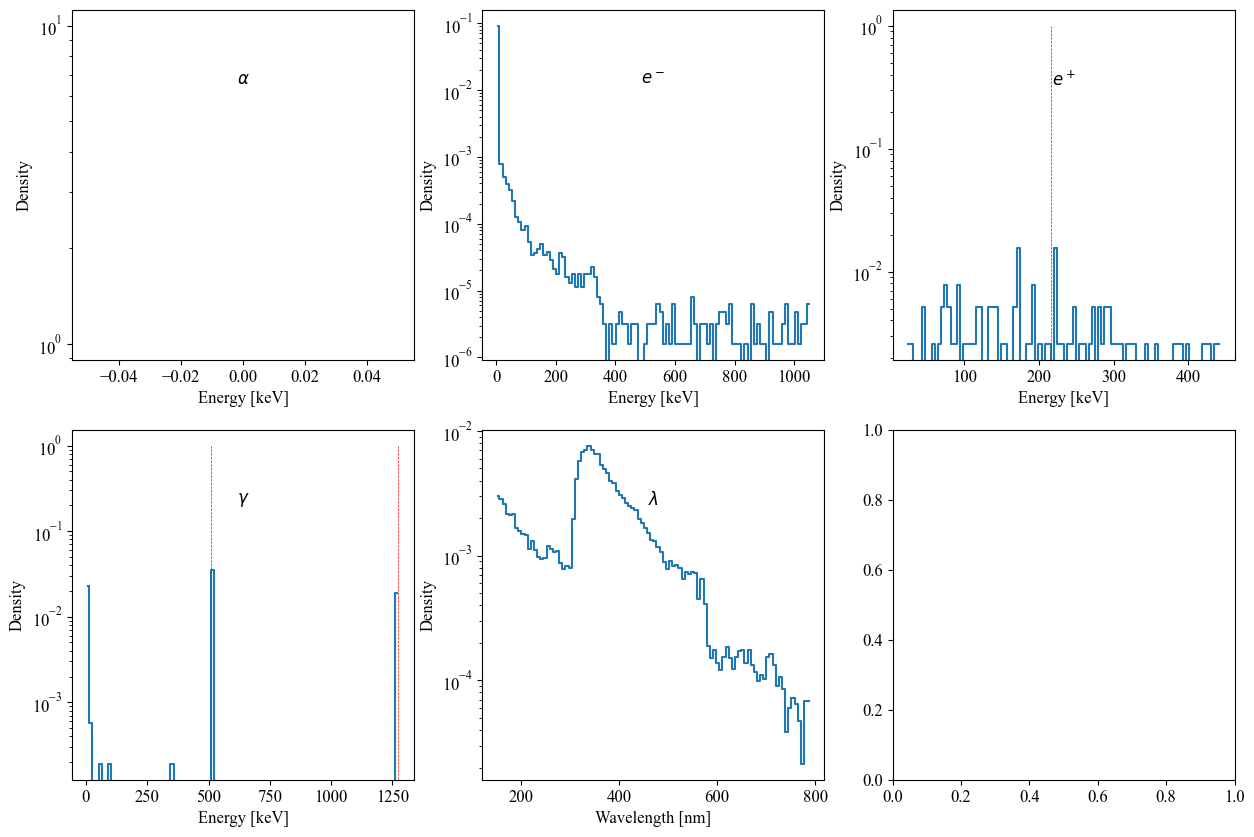

In [227]:
filename = "Na22.csv"
path = output_directory + filename

Na22 = Decay(path)
Na22.plot()

/home/jakob/myenv/lib/python3.12/site-packages/numpy/lib/_histograms_impl.py:902: RuntimeWarning: invalid value encountered in divide
  return n/db/n.sum(), bin_edges


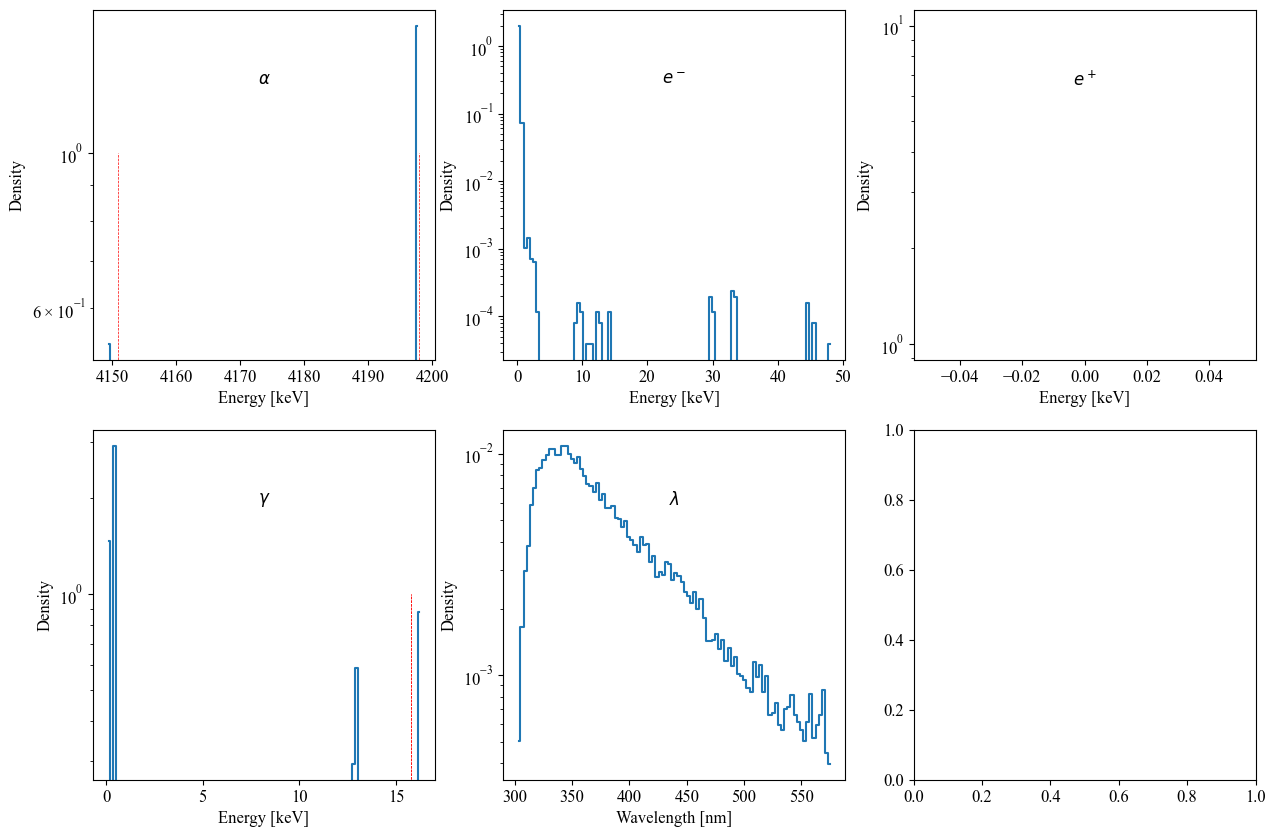

In [228]:
filename = "U238.csv"
path = output_directory + filename

U238 = Decay(path)
U238.plot()

/home/jakob/myenv/lib/python3.12/site-packages/numpy/lib/_histograms_impl.py:902: RuntimeWarning: invalid value encountered in divide
  return n/db/n.sum(), bin_edges


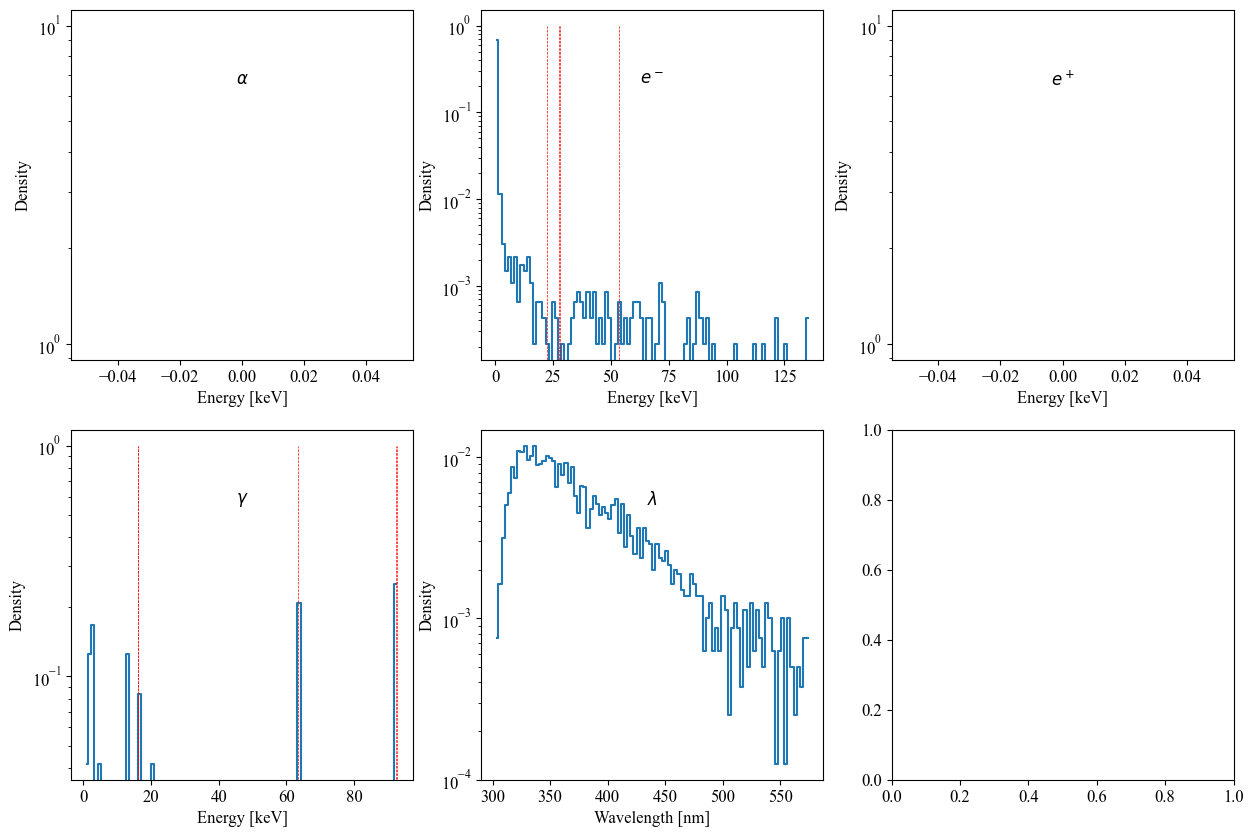

In [229]:
filename = "Th234.csv"
path = output_directory + filename

Th234 = Decay(path)
Th234.plot()

/home/jakob/myenv/lib/python3.12/site-packages/numpy/lib/_histograms_impl.py:902: RuntimeWarning: invalid value encountered in divide
  return n/db/n.sum(), bin_edges


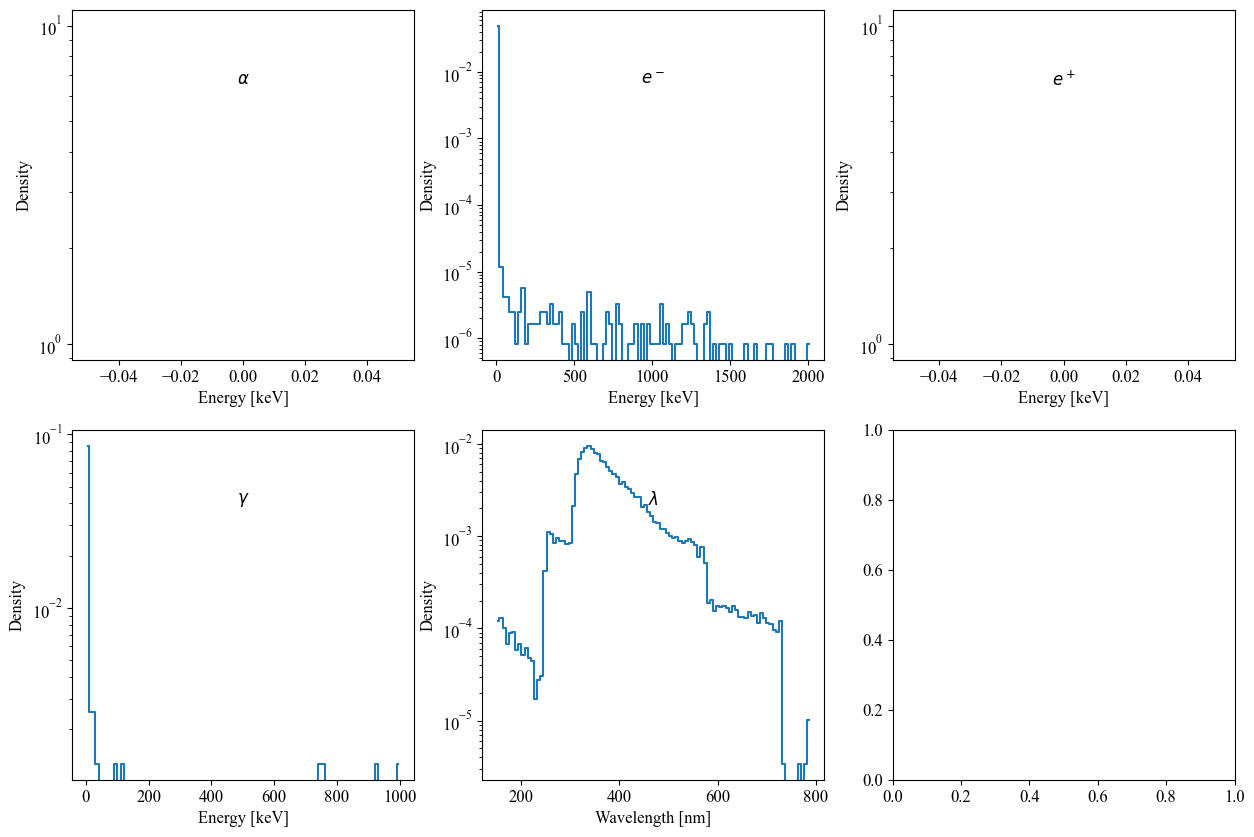

In [232]:
filename = "Pa234m.csv"
path = output_directory + filename

Pa234m = Decay(path)
Pa234m.plot()

/home/jakob/myenv/lib/python3.12/site-packages/numpy/lib/_histograms_impl.py:902: RuntimeWarning: invalid value encountered in divide
  return n/db/n.sum(), bin_edges


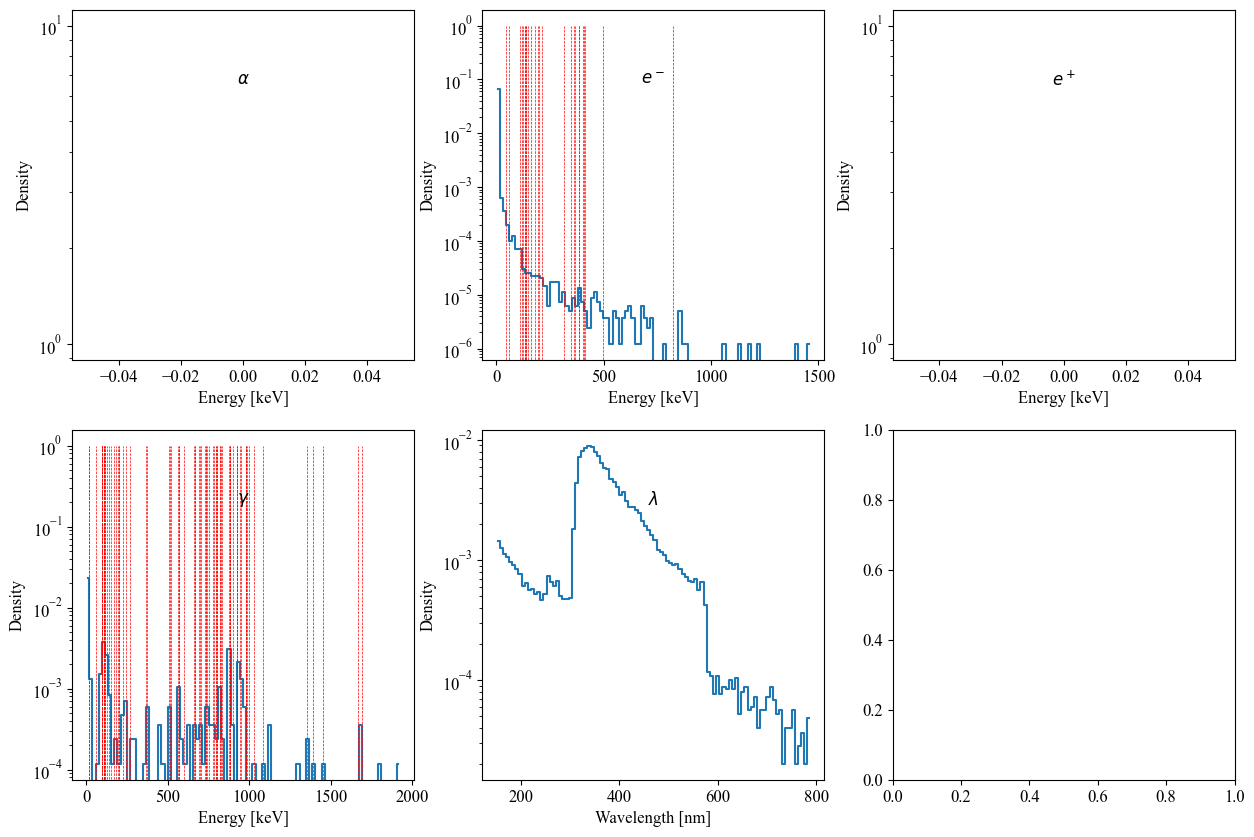

In [234]:
filename = "Pa234.csv"
path = output_directory + filename

Pa234 = Decay(path)
Pa234.plot()

/home/jakob/myenv/lib/python3.12/site-packages/numpy/lib/_histograms_impl.py:902: RuntimeWarning: invalid value encountered in divide
  return n/db/n.sum(), bin_edges


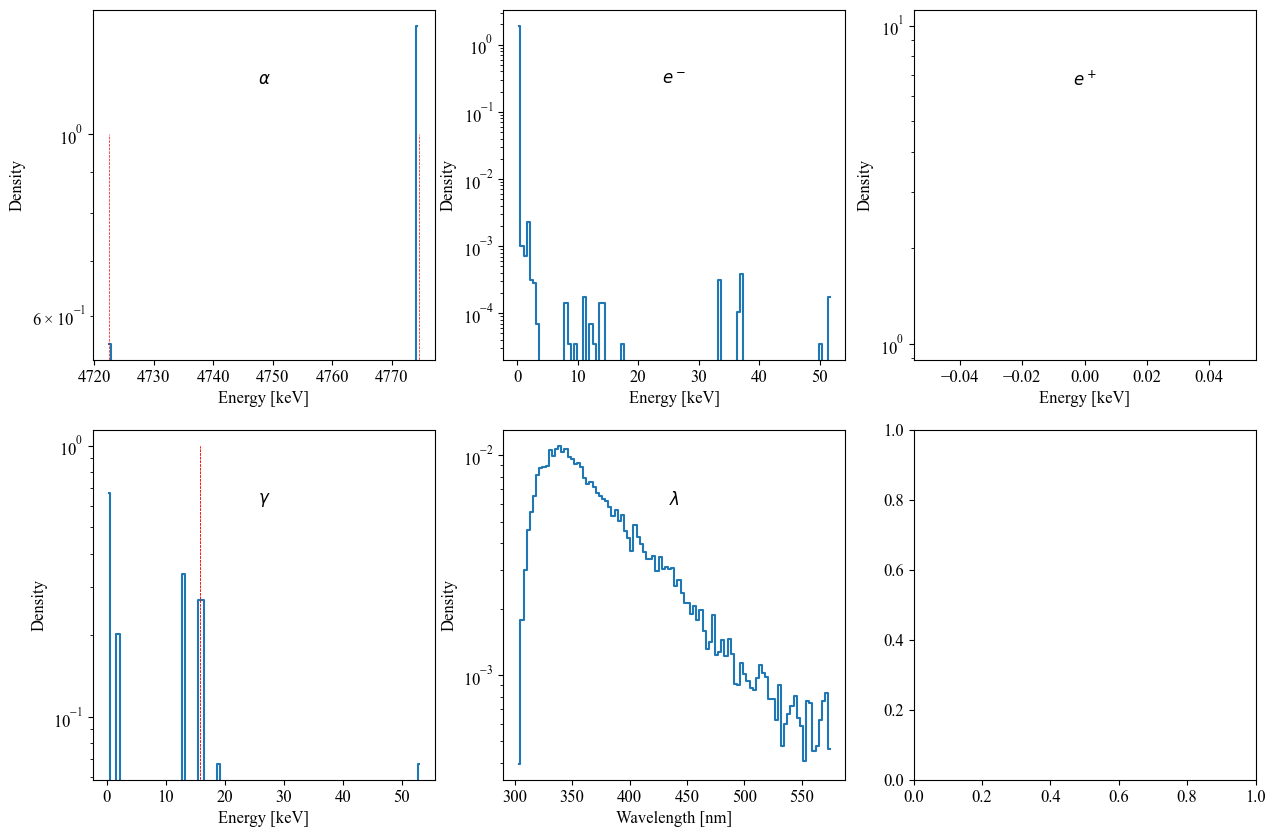

In [242]:
filename = "U234.csv"
path = output_directory + filename

U234 = Decay(path)
U234.plot()

In [235]:
ref = read_df_from_url("https://www-nds.iaea.org/relnsd/v1/data?fields=decay_rads&nuclides=pa234&rad_types=g")

In [241]:
ref["energy"][ref["intensity"]> 1]

12       62.700
20       99.860
26      131.300
36      152.710
45      186.150
54      203.120
60      226.500
61      227.250
74      249.220
78      272.280
83      293.790
109     369.500
110     372.000
134     458.680
151     506.750
175     565.200
176     568.900
177     569.500
212     666.500
213     669.700
223     692.600
226     699.030
229     705.900
241     733.390
242     738.000
244     742.810
249     755.000
265     786.270
270     796.100
275     805.800
283     819.200
284     824.200
285     825.100
288     831.500
301     876.000
302     880.500
303     880.500
306     883.240
309     898.670
315     925.000
316     926.000
318     926.720
324     946.000
325     947.700
332     980.300
333     980.300
335     984.200
397    1352.900
403    1393.900
518      16.678
521      94.657
523      98.439
525     111.238
526     112.645
528     114.446
Name: energy, dtype: float64